Python code for generating figures used in the paper "What Determines the Sizes of Bars in Spiral Galaxies?" (Erwin 2019, submitted)

## Setup

### General Setup

In [1]:
%pylab inline

matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 20

# kludge to fix matplotlib's font_manager bug which mistakenly ID's "Times New Roman Bold.ttf" as
# indicating a "roman" (i.e., "normal") weight
# try:
#     del matplotlib.font_manager.weight_dict['roman']
# except KeyError:
#     pass
# matplotlib.font_manager._rebuild()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['mean']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [4]:
import os, math
import numpy as np
import scipy.stats
from astropy.io import fits

# local modules
import angle_utils as angles
import plotutils as pu

# CHANGE THIS TO POINT TO APPROPRIATE LOCAL DIRECTORY (DEFAULT = SAME DIRECTORY AS THIS NOTEBOOK)
#projDir = '/Users/erwin/Documents/Working/Papers/Paper-BarProfiles/public/'
projDir = os.getcwd() + "/"
sys.path.append(projDir)
import datautils as du

# The following is from Eqn. 2 of Sheth+2010 (http://adsabs.harvard.edu/abs/2010PASP..122.1397S)
# where zeroPoint_s4g is the AB mag zero point, assuming data values are MJy sr^-1, and the next
# two values are the effective zero points converting pixel values to surface brightness for images
# with 0.75 arcsec/pixel (S4G images) and 0.6 arcsec/pixel (Spitzer archival images), respectively.
zeroPoint_s4g = 20.472
zeroPoint_sb_075 = zeroPoint_s4g + 2.5*np.log10(0.75**2)
zeroPoint_sb_060 = zeroPoint_s4g + 2.5*np.log10(0.6**2)

dataDir = projDir + "data/"
imagesDir = dataDir + "images/"
s4gdata = du.ReadCompositeTable(dataDir + "s4gbars_table.dat", columnRow=26, dataFrame=True)

# This is where the best-fit parameter coefficients are saved
bestfitParamsFile = projDir + "bestfit_parameters.txt"

# CHANGE THIS TO POINT TO APPROPRIATE LOCAL DIRECTORY -- this is where PDF figures will be saved
baseDir = "/Users/erwin/Documents/Working/Papers/Paper-BarProfiles/"
plotDir = baseDir + "plots/"

nDisksTotal = len(s4gdata.name)

mm = np.arange(8,12,0.01)

# set the following to True in order to save the figures as PDF files
savePlots = False

## Useful Code

### Plot labels

In [4]:
# useful definitions for printing and plotting labels

xtmstar = r"$\log \: (M_{\star} / M_{\odot})$"
xth_kpc = r"Disc scale length $h$ [kpc]"
xtRe_kpc = r"Galaxy half-light radius $R_{e}$ [kpc]"
xtfgas = r"$\log \: (M_{\rm HI} / M_{\star})$"
xtHtype = r"Hubble Type $T$"
ytbarsize_kpc = r"Bar size $a_{\rm vis}$ [kpc]"
ytresid = r"Residuals: $\log \, (a_{\rm vis}) - \log \, ({\rm predicted})$"
ytresid_Re = r"Residuals: $\log \, R_{e, {\rm obs}} - \log \, ({\rm predicted})$"
ytresid_h = r"Residuals: $\log \, h - \log \, ({\rm predicted})$"
ytmu = r"$\mu_{3.6}$ [AB mag arcsec$^{-2}$]"

s4g_txt = r"S$^{4}$G"
s4g_fwhm = r"S$^{4}$G $\langle$FWHM$\rangle$"
s4g_2fwhm = r"$2 \times$ S$^{4}$G $\langle$FWHM$\rangle$"


In [26]:
reload(angles)

<module 'angle_utils' from '/Users/erwin/Documents/Working/Papers/Paper-BarProfiles/public/angle_utils.py'>

In [27]:
def GetYLimits( radii, intensityProfile, ZP=None ):
    if ZP is None:
        maxVal = max(intensityProfile)
        minVal = min(intensityProfile)
        if (minVal < 1.0e-3):
            minVal = 1.0e-3
        minVal = 10**(math.floor(math.log10(minVal)))
        maxVal = 10**(math.ceil(math.log10(maxVal)))
    else:
        sbProfile = ZP - 2.5*np.log10(intensityProfile)
        # "min" and "max" for surface-brightness
        minVal = math.ceil(np.nanmax(sbProfile))
        maxVal = math.floor(np.nanmin(sbProfile))
    return (minVal, maxVal)


def MakeIsophoteAndProfilePlots( fname, xc,yc, imageWidth, diskPA, inclination, barPA, sma,
            boxPA, r_box, profileRadius, pixSize=0.75, ZP=None,
            squareProfPlot=False, axisLabelSize=9, figMode="standard" ):
    """
    Make a two-panel plot, with isophotes on left side and bar-major + bar-minor profile
    plots on right side.
    
    Parameters
    ----------
    fname : str
        path to image file
        
    xc, yc : int, int
        x- and y-coordinates of galaxy center within image
    
    imageWidth : int
        width of contour plot, in pixels
    
    diskPA, inclination : float, float
        PA and inclination of galaxy disk, in degrees
    
    barPA : float
        PA of bar on image, in degrees
    
    sma : float
        semi-major axis of bar (observed), in arcsec
    
    boxPA : float
        PA of B/P on image, in degrees
    
    r_box : float
        semi-major axis of B/P bulge (observed), in arcsec
        (set = 0 for no B/P bulge)
    
    profileRadius : float
        radius for bar-major-axis and bar-minor-axis profiles, in pixels
    
    pixSize : float, optional
        pixel size in arcsec
    
    ZP : float, optional or None
        zero point for converting data values (counts/pix) into surface-brightness
        (mag/arcsec^2)
    
    figMode : str, optional
        "standard" = for Figs.3--5 in paper
        "nice" = for Fig.1 in paper
    """

    levs = np.arange(-1.5,2.5,0.1)

    rbox_dp = angles.deprojectr(boxPA - diskPA, inclination, r_box)

    rr_barmaj,ii_barmaj = pu.GetProfileAtAngle(fits.getdata(fname), xc,yc, barPA + 90, profileRadius, width=1, oneSided=False)
    rr_barmaj = 1.0 + np.arange(len(rr_barmaj))
    rr_barmaj_arcsec = 0.75*(rr_barmaj - (profileRadius + 0.5))

    deprojFactor_majoraxis = angles.deprojectr(barPA - diskPA, inclination, 1.0)
    rr_barmaj_arcsec_dp = deprojFactor_majoraxis * rr_barmaj_arcsec

    # 2. Get bar-minor-axis profile and compute deprojected radii
    barMinorPA_obs = angles.minoraxis(barPA, diskPA, inclination)
    rr_barmin,ii_barmin = pu.GetProfileAtAngle(fits.getdata(fname), xc,yc, barMinorPA_obs + 90, profileRadius, width=1, oneSided=False)
    rr_barmin = 1.0 + np.arange(len(rr_barmin))
    rr_barmin_arcsec = 0.75*(rr_barmin - (profileRadius + 0.5))
    deprojFactor_minoraxis = angles.deprojectr(barMinorPA_obs - diskPA, inclination, 1.0)
    rr_barmin_arcsec_dp = deprojFactor_minoraxis * rr_barmin_arcsec


    # 3. Get image data and plot contours   [left, bottom, width, height]
    imdata_m3 = median_filter(fits.getdata(fname), 3)
    fig = figure(figsize=(10,4))
    if figMode == "nice":   # e.g. Fig.1 of paper
        ax1 = fig.add_axes([0.05,0.15, 0.35,0.8])   # left, bottom, width, height
    else:
        ax1 = fig.add_axes([0.07,0.15, 0.35,0.8])   # left, bottom, width, height
    pu.nicecont(imdata_m3, xc,yc,1.5*profileRadius, log=True,levels=levs,
                            pix=pixSize, printAxisLabels='x',axisLabel='arcsec',
                            labelSize=axisLabelSize, color='0.4', axesObj=ax1)
    # Draw major-axis PA line, bar radius, minor-axis PA line
    pu.DrawPALine(barPA, 0.5*profileRadius, fmt='b-', linewidth=1.5, alpha=0.75, axesObj=ax1)
    pu.DrawPALine(barPA, sma, fmt='b-', alpha=0.5, addDots=True, dot_ms=8, axesObj=ax1)
    pu.DrawPALine(barMinorPA_obs, 0.5*profileRadius, 'b--', alpha=0.75, axesObj=ax1)
    ax1.axhline(0, color='0.5', linewidth=0.5)
    ax1.axvline(0, color='0.5', linewidth=0.5)
    # add red arrow for B/P bulge, if present
    if (rbox_dp > 0.0):
        arrowWidth = 0.035 * imageWidth*pixSize
        arrowLWidth = 0.002 * imageWidth*pixSize
        pu.DrawArrow((0,0), PA=boxPA, radius=r_box, lineWidth=2*arrowLWidth, headWidth=arrowWidth, color='r')
        pu.DrawArrow((0,0), PA=boxPA + 180, radius=r_box, lineWidth=2*arrowLWidth, headWidth=arrowWidth, color='r')


    # Profile plot   [left, bottom, width, height]
    # this (assuming figsize = ()) gets us the approximate standard 1.3 aspect ratio
    # of a matplotlib plot
    ax2 = fig.add_axes([0.55,0.15, 0.42,0.8])
    if ZP is None:
        ax2.semilogy(rr_barmaj_arcsec_dp, ii_barmaj, "k")
        ax2.semilogy(rr_barmin_arcsec_dp, ii_barmin, "0.5", lw=0.5)
        ylimits = ax2.get_ylim() #ylim( blah, blah )
        if (ylimits[0] < 0.01):
            ax2.set_ylim([0.001, ylimits[1]])
    else:
        mags_barmaj = ZP - 2.5*np.log10(ii_barmaj)
        mags_barmin = ZP - 2.5*np.log10(ii_barmin)
        ax2.plot(rr_barmaj_arcsec_dp, mags_barmaj, "k")
        ax2.plot(rr_barmin_arcsec_dp, mags_barmin, "0.5", lw=0.5)
        ylimits = ax2.get_ylim()
        ax2.set_ylim(ylimits[1], ylimits[0])
    ax2.axvline(0, color='k', linestyle=":")
    ax2.axvline(deprojFactor_majoraxis*sma, color="b")
    ax2.axvline(-deprojFactor_majoraxis*sma, color="b")
    if (rbox_dp > 0.0):
        ax2.axvline(rbox_dp, color='r');plt.axvline(-rbox_dp, color='r')

    # trim x-axis range to include bar-major-axis profile; don't worry about
    # extended (deprojected) minor-axis profile
    xLimit = 1.1*max(rr_barmaj_arcsec_dp)
    yLimits = GetYLimits(rr_barmaj_arcsec_dp, ii_barmaj, ZP=ZP)
    ax2.set_xlim(-xLimit, xLimit)
    ax2.set_ylim(yLimits[0], yLimits[1])
    ax2.set_xlabel("Deprojected radius [arc sec]", fontsize=axisLabelSize)
    if ZP is None:
        ytitle = "Intensity"
    else:
        ytitle = ytmu
    ax2.set_ylabel(ytitle, fontsize=axisLabelSize)


# Figures

Most of the figures in the paper are composites (assembled in Adobe Illustrator). Code for the individual panels that make up each figure is provided below.

## Figure 1 -- Examples of Peak+Shoulder Bar Profiles

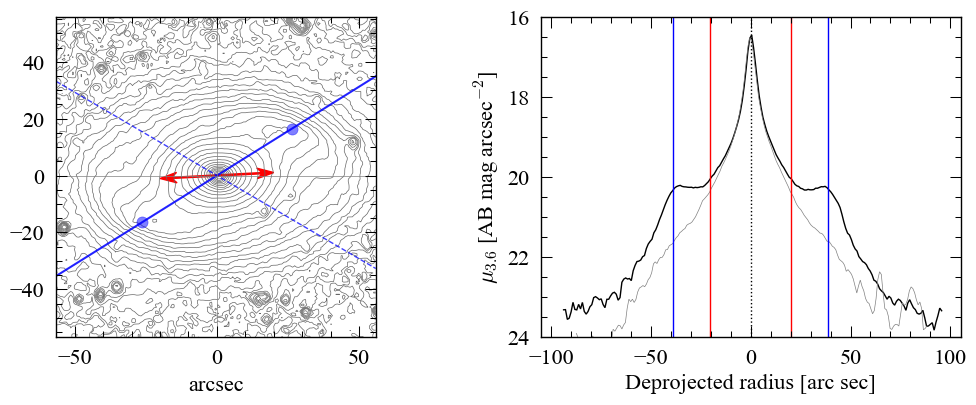

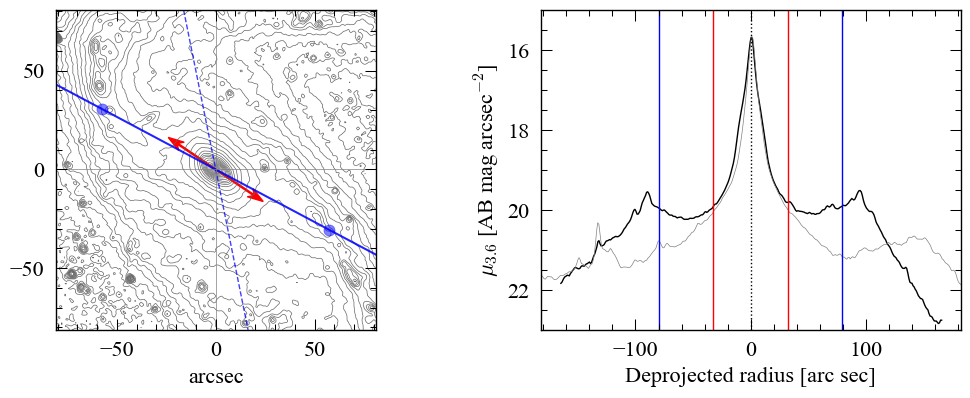

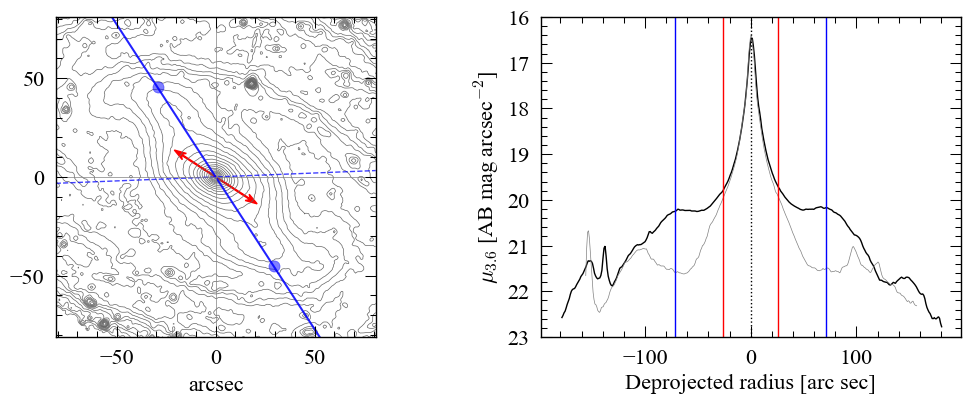

In [30]:
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16

# NGC 1079
fname0 = imagesDir + "n1079irac1ss.fit"
pixSize0 = 0.75
imageWidth0 = 140
diskPA0, inc0 = 87, 53
barPA0, sma0 = 122, 31
boxPA0, r_box0 = 93, 20
MakeIsophoteAndProfilePlots(fname0, 295.56,286.67, imageWidth0, diskPA0, inc0, barPA0, 
sma0, boxPA0, r_box0, 100, pixSize=pixSize0, ZP=zeroPoint_s4g, axisLabelSize=16, figMode="nice")
if savePlots:
    savefig(fplots + "n1079_isophotes+profiles.pdf")

# NGC 2442
fname1 = imagesDir + "n2442irac1_derot_cutout.fit"
pixSize1 = 0.6
imageWidth1 = 240
diskPA1, inc1 = 40, 62
barPA1, sma1 = 62, 65
boxPA1, r_box1 = 56, 29
MakeIsophoteAndProfilePlots(fname1, 438.,411.4, imageWidth1, diskPA1, inc1, barPA1, 
sma1, boxPA1, r_box1, 180, pixSize=pixSize1, ZP=zeroPoint_s4g, axisLabelSize=16, figMode="nice")
if savePlots:
    savefig(fplots + "n2442_isophotes+profiles.pdf")

# NGC 3992
fname2 = imagesDir + "n3992irac1_derot_cutout_ss.fit"
pixSize2 = 0.6
imageWidth2 = 180
diskPA2, inc2 = 69, 56
barPA2, sma2 = 33, 54
boxPA2, r_box2 = 57, 25
MakeIsophoteAndProfilePlots(fname2, 742,742, imageWidth2, diskPA2, inc2, barPA2, 
sma2, boxPA2, r_box2, 180, pixSize=pixSize2, ZP=zeroPoint_s4g, axisLabelSize=16, figMode="nice")
if savePlots:
    savefig(fplots + "n3992_isophotes+profiles.pdf")


## Figure 2 -- Distributions of Stellar Mass

## Figure 3 -- Examples of Exponental Bar Profiles

## Figure 4 -- Examples of Two-Slope Bar Profiles

## Figure 5 -- Examples of Flat-Top Bar Profiles

## Figure 6 -- Stellar-mass Distributions of Bar-Profile Types

## Figure 7 -- Distributions of Bar-Profile Types Versus T, gas mass fraction, and g-r

## Figure 8 -- Distributions of Bar-Profile Types Versus Bar Size and Strength

## Figure 9 -- Frequency of B/P Bulges Versus Stellar Mass

## Figure 10 -- Frequency of B/P Bulges Versus Rotation Velocity

## Figure 11 -- Frequency of P+Sh Profiles Versus Stellar Mass

## Figure A1 -- Examples of Classification Plots

### Useful Functions

### Subsamples

Importing the variables defined in `sample_defs.py` provides lists of int values, which can be used to index numpy 1D arrays, thereby defining different subsamples of S4G.

E.g., the R_e values of all the barred galaxies can be defined as
    
    s4gdata.Re_kpc[ii_barred]

**Location of subsample definitions:** 

projDir + sample_defs.py

In [5]:
from sample_defs import *

For reference, here are the definitions in that file:

In [6]:
# "limited2" or "lim2" = D <= 30 Mpc
# "m9to11 = logmstar = 9--11


# general subsamples: all barred, all unbarred, all spirals
ii_barred = [i for i in range(nDisksTotal) if s4gdata.sma[i] > 0]
ii_unbarred = [i for i in range(nDisksTotal) if s4gdata.sma[i] <= 0]

ii_spirals = [i for i in range(nDisksTotal) if s4gdata.t_s4g[i] > -0.5]


# Limited subsample 2: spirals with D <= 30 Mpc -- 856 galaxies: 483 barred, 373 unbarred
ii_all_limited2 = [i for i in ii_spirals if s4gdata.dist[i] <= 30]
ii_barred_limited2 = [i for i in ii_all_limited2 if i in ii_barred]
ii_unbarred_limited2 = [i for i in ii_all_limited2 if i not in ii_barred]

# Parent Spiral Sample: spirals with D <= 30 Mpc + logMstar = 9--11:
ii_all_limited2_m9to11 = [i for i in ii_all_limited2 if s4gdata.logmstar[i] >= 9 and s4gdata.logmstar[i] <= 11]
ii_barred_limited2_m9to11 = [i for i in ii_all_limited2_m9to11 if i in ii_barred]



# Spirals with R_e *and* h
ii_all_Reh = [i for i in ii_spirals if s4gdata.Re_kpc[i] > 0 and s4gdata.h_kpc[i] > 0]
ii_barred_Reh = [i for i in ii_all_Reh if i in ii_barred]
ii_unbarred_Reh = [i for i in ii_all_Reh if i not in ii_barred]


ii_all_Reh_m9to11 = [i for i in ii_spirals if s4gdata.logmstar[i] >= 9 and s4gdata.logmstar[i] <= 11 and s4gdata.Re_kpc[i] > 0 and s4gdata.h_kpc[i] > 0]
ii_barred_Reh_m9to11 = [i for i in ii_all_Reh_m9to11 if i in ii_barred]
ii_unbarred_Reh_m9to11 = [i for i in ii_all_Reh_m9to11 if i not in ii_barred]

ii_all_limited2_Reh = [i for i in ii_all_Reh if s4gdata.dist[i] <= 30]
ii_barred_limited2_Reh = [i for i in ii_all_limited2_Reh if i in ii_barred]
ii_unbarred_limited2_Reh = [i for i in ii_all_limited2_Reh if i not in ii_barred]

# Main Spiral Sample: Spirals with D < 30 Mpc, valid R_e *and* h, *and* logMstar = 9--11:
ii_all_lim2m9to11_Reh = [i for i in ii_all_limited2_Reh if s4gdata.logmstar[i] >= 9 and s4gdata.logmstar[i] <= 11]
ii_barred_lim2m9to11_Reh = [i for i in ii_all_lim2m9to11_Reh if i in ii_barred]
ii_unbarred_lim2m9to11_Reh = [i for i in ii_all_lim2m9to11_Reh if i not in ii_barred]


# useful aliases which are more directly descriptive
ii_all_D30 = ii_all_limited2
ii_all_D30_m9to11 = ii_all_limited2_m9to11
ii_barred_D30_m9to11 = ii_barred_limited2_m9to11
ii_barred_D30_m9to11_Reh = ii_barred_lim2m9to11_Reh
